In [ ]:
pip install full-fred

     |████████████████████████████████| 47 kB 5.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from full_fred.fred import Fred
from datetime import datetime
from time import sleep
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
fred = Fred('drive/MyDrive/Machine Learning Project/key.txt') # key.txt contains a valid FRED API key

# Step 1: Data Collection

**Conditions for Series Selection:**

1. The series must start on or before January 1980 and end on or after December 2020.

2. The series must not contain any missing values during the time period from January 1980 to December 2020.

3. The series must not be discontinued.

4. The series must be monthly (or convertible to monthly).

5. The series must belong to one of the five categories:

> 1. Money, Banking, & Finance (ID: 32991)

> 2. Population, Employment, & Labor Markets (ID: 10)

> 3. National Accounts (ID: 32992)

> 4. Production and Business Activity (ID: 1)

> 5. Prices (ID: 32455)

6. The series must not belong to the Current Population Survey (Household Survey) category (which is a subcategory of Population, Employment, & Labor Markets) because the data collected from this survey includes the unemployment rate.


In [ ]:
def test_duplicate_series(data, new_data):
  data_columns = data.columns
  new_data_columns = new_data.columns
  for column in data_columns:
    if column in new_data_columns and column != 'date':
      return True
  return False

In [ ]:
def find_series(id, categories):
  global data
  if len(categories) == 0: # base case
    try:
      category_series = fred.get_series_in_a_category(id)['seriess']
    except KeyError as error:
      sleep(sleep_time)
      category_series = fred.get_series_in_a_category(id)['seriess']
    new_data = pd.DataFrame()
    for j in range(len(category_series)):
      id = category_series[j]['id']
      title = category_series[j]['title']
      frequency = category_series[j]['frequency_short']
      start_date = datetime.strptime(category_series[j]['observation_start'], '%Y-%m-%d')
      end_date = datetime.strptime(category_series[j]['observation_end'], '%Y-%m-%d')
      if (title.find('(DISCONTINUED)') == -1 and start_date <= min_date and end_date >= max_date and frequency in ('D', 'W', 'M')):
        try:
          series = (fred.get_series_df(series_id = id, frequency = "m"))[['date', 'value']]
        except KeyError as error:
          sleep(sleep_time)
          series = (fred.get_series_df(series_id = id, frequency = "m"))[['date', 'value']]
        for i in range(len(series)):
          series = series.copy()
          series.loc[i, 'date'] = datetime.strptime(series['date'][i], '%Y-%m-%d')
        series = series[series.date >= min_date]
        series = series[series.date <= max_date]
        if (series['value'].isin(['.'])).sum() == 0:
          series.columns = ['date', id]
          if len(new_data.columns) == 0:
            new_data = series
          else:
            new_data = new_data.merge(series, on = 'date')
    return new_data
  else: # recursive step
    for i in range(len(categories)):
      name = categories[i]['name']
      id = categories[i]['id']
      try:
        new_categories = fred.get_child_categories(id)['categories']
      except KeyError as error:
        sleep(sleep_time)
        new_categories = fred.get_child_categories(id)['categories']
      new_data = find_series(id, new_categories)
      if len(data.columns) == 0 and len(new_data.columns) > 0:
        data = new_data
      elif len(data.columns) > 0 and len(new_data.columns) > 0:
        if test_duplicate_series(data, new_data) == False:
          data = data.merge(new_data, on = 'date')
    return data

In [ ]:
def save_series(id, categories, file_path):
  global data
  data = pd.DataFrame()
  df = find_series(id, categories)
  df.to_csv(file_path, index = False)

In [ ]:
data = pd.DataFrame()
sleep_time = 100
min_date = datetime.strptime('1960-01-01', '%Y-%m-%d')
max_date = datetime.strptime('2020-12-31', '%Y-%m-%d')

108 series in Money, Banking, and Finance meet the above criteria.

157 series in Population, Employment, and Labor Markets meet the above criteria.

37 series in National Accounts meet the above criteria.

52 series in Production and Business Activity meet the above criteria.

446 series in Prices meet the above criteria.

In [ ]:
# 11m
save_series(32991, fred.get_child_categories(32991)['categories'],
            'drive/MyDrive/Machine Learning Project/data/MoneyBankingAndFinance.csv')

Error Message: Too Many Requests.  Exceeded Rate Limit
Error Message: Too Many Requests.  Exceeded Rate Limit


In [ ]:
# 5m 2s
save_series(10, fred.get_child_categories(10)['categories'][1:],
            'drive/MyDrive/Machine Learning Project/data/PopulationEmploymentAndLaborMarkets.csv')

Error Message: Too Many Requests.  Exceeded Rate Limit


In [ ]:
# 5m 45s
save_series(32992, fred.get_child_categories(32992)['categories'],
            'drive/MyDrive/Machine Learning Project/data/NationalAccounts.csv')

Error Message: Too Many Requests.  Exceeded Rate Limit


In [ ]:
# 2m 26s
save_series(1, fred.get_child_categories(1)['categories'],
            'drive/MyDrive/Machine Learning Project/data/ProductionAndBusinessActivity.csv')

In [ ]:
# 14m
save_series(32455, fred.get_child_categories(32455)['categories'],
            'drive/MyDrive/Machine Learning Project/data/Prices.csv')

Error Message: Too Many Requests.  Exceeded Rate Limit
Error Message: Too Many Requests.  Exceeded Rate Limit


# Step 2: Data Exploration

A. Load the data into Python.

In [ ]:
df_mbf = pd.read_csv('drive/MyDrive/Machine Learning Project/data/MoneyBankingAndFinance.csv')
print(df_mbf.head())
df_pel = pd.read_csv('drive/MyDrive/Machine Learning Project/data/PopulationEmploymentAndLaborMarkets.csv')
print(df_pel.head())
df_na = pd.read_csv('drive/MyDrive/Machine Learning Project/data/NationalAccounts.csv')
print(df_na.head())
df_pba = pd.read_csv('drive/MyDrive/Machine Learning Project/data/ProductionAndBusinessActivity.csv')
print(df_pba.head())
df_prices = pd.read_csv('drive/MyDrive/Machine Learning Project/data/Prices.csv')
print(df_prices.head())

                  date   AAA   BAA  ...   TOTALSL  TOTALSLAR  TOTALTCU
0  1960-01-01 00:00:00  4.61  5.34  ...  56.01558       0.10     2.923
1  1960-02-01 00:00:00  4.56  5.34  ...  56.36463       7.48     2.850
2  1960-03-01 00:00:00  4.49  5.25  ...  56.86288      10.61     2.810
3  1960-04-01 00:00:00  4.45  5.20  ...  57.71140      17.91     2.963
4  1960-05-01 00:00:00  4.46  5.28  ...  57.95103       4.98     2.867

[5 rows x 109 columns]
                  date  PAYEMS  PAYNSA  ...  CEU9093161101  CEU9093200001  USGOVT
0  1960-01-01 00:00:00   54274   53448  ...         2350.3         2161.7    8307
1  1960-02-01 00:00:00   54513   53422  ...         2380.0         2170.0    8326
2  1960-03-01 00:00:00   54454   53494  ...         2374.7         2182.3    8525
3  1960-04-01 00:00:00   54813   54285  ...         2364.6         2192.4    8534
4  1960-05-01 00:00:00   54475   54349  ...         2351.2         2213.8    8432

[5 rows x 158 columns]
                  date  B039RC1M02

In [ ]:
def merge_dfs(dfs):
  df_all = pd.DataFrame()
  for i in range(len(dfs)):
    if i == 0:
      df_all = dfs[i]
    else:
      df_all = df_all.merge(dfs[i], on = 'date')
  return df_all

In [ ]:
df = merge_dfs([df_mbf, df_pel, df_na, df_pba, df_prices])

for i in range(len(df['date'])):
  df = df.copy()
  df.loc[i, 'date'] = datetime.strptime(df['date'][i].split()[0], '%Y-%m-%d')

In [ ]:
unrate_df = fred.get_series_df('UNRATE', observation_start = '1960-01-01', observation_end = '2020-12-01')[['date', 'value']]

for i in range(len(unrate_df['date'])):
  unrate_df = unrate_df.copy()
  unrate_df.loc[i, 'date'] = datetime.strptime(unrate_df['date'][i], '%Y-%m-%d')

for i in range(len(unrate_df['value'])):
  unrate_df.loc[i, 'value'] = float(unrate_df['value'][i])

unrate_df['value'] = unrate_df['value'].astype(np.float)

unrate_df.columns = ['date', 'UNRATE']

In [ ]:
unrate_chg_df = fred.get_series_df('UNRATE', units = 'chg', observation_start = '1960-01-01', observation_end = '2020-12-01')[['date', 'value']]

for i in range(len(unrate_chg_df['date'])):
  unrate_chg_df = unrate_chg_df.copy()
  unrate_chg_df.loc[i, 'date'] = datetime.strptime(unrate_chg_df['date'][i], '%Y-%m-%d')

for i in range(len(unrate_chg_df['value'])):
  unrate_chg_df.loc[i, 'value'] = float(unrate_chg_df['value'][i])

unrate_chg_df['value'] = (unrate_chg_df['value'] > 0).astype(np.int)

unrate_chg_df.columns = ['date', 'UNRATECHG']

In [ ]:
df = df.merge(unrate_df, on = 'date')
df = df.merge(unrate_chg_df, on = 'date')
print(df.head())

                  date   AAA   BAA  ...  PCU22112222112243  UNRATE  UNRATECHG
0  1960-01-01 00:00:00  4.61  5.34  ...               17.6     5.2          0
1  1960-02-01 00:00:00  4.56  5.34  ...               17.8     4.8          0
2  1960-03-01 00:00:00  4.49  5.25  ...               17.8     5.4          1
3  1960-04-01 00:00:00  4.45  5.20  ...               17.8     5.2          0
4  1960-05-01 00:00:00  4.46  5.28  ...               17.8     5.1          0

[5 rows x 803 columns]


B. Report the number of data samples and the number of features.

In [ ]:
print('number of data samples =', len(df))

features = df.drop(['date', 'UNRATE', 'UNRATECHG'], axis = 1)
print('number of features =', len(features.columns))

number of data samples = 732
number of features = 800


C. What is the data type for the output variable?

In [ ]:
print(type(df['UNRATE'][0]))
print(type(df['UNRATECHG'][0])) # 0 (decrease) or 1 (increase)

<class 'numpy.float64'>
<class 'numpy.int64'>


D. Select one or a few data samples, and visualize your data in a proper way.

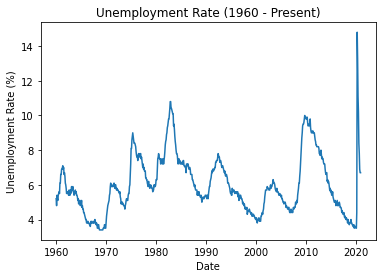

In [ ]:
plt.plot(df['date'], df['UNRATE'])
plt.title('Unemployment Rate (1960 - Present)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.show()

E. Perform basic inspection on your data, such as feature types, feature statistics, missing values, etc.

In [ ]:
df.describe()

,AAA,BAA,DFF,FEDFUNDS,FF,AAA10YM,AAAFFM,BAA10YM,BAAFFM,T10YFFM,T1YFFM,T5YFFM,TB3SMFFM,TB6SMFFM,DPRIME,MPRIME,WPRIME,DTB3,DTB6,TB3MS,TB6MS,WTB3MS,WTB6MS,GS1,GS10,GS20,GS3,GS5,BOGMBASE,BOGMBBM,MBCURRCIR,SNBMONTBASE,NONBORRES,TOTRESNS,CURRDD,CURRNS,CURRSL,DEMDEPNS,DEMDEPSL,M1NS,...,WPU0914,WPU0915,WPU091501,WPU091506,WPU092,WPU0922,WPU07,WPU0711,WPU071102,WPU0712,WPU071201,WPU0713,WPU071301,WPU071303,WPU071304,WPUSI012011,WPUSISTEEL1,WPUSISTEEL2,WPUSISTEEL3,PPIIDC,WPU03,WPU031502,WPU032601,WPU0381,WPU0382,WPS141,WPS141101,WPU141,WPU1411,WPU141101,PCU311225311225P,PCU3114113114111,PCU3114113114114,PCU311422311422,PCU311513311513P,PCU312111312111P,PCU22112222112242,PCU22112222112243,UNRATE,UNRATECHG
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,7.320000e+02,7.320000e+02,7.320000e+02,732.000000,7.320000e+02,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,...,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,6.975738,7.987937,4.918497,4.918497,4.918087,1.011107,2.057514,2.023306,3.069713,1.046407,0.046120,0.718306,-0.451475,-0.317445,7.093443,7.094221,7.093743,4.466749,4.600779,4.466749,4.600779,4.467145,4.601516,4.964344,5.964631,6.217978,5.377404,5.636571,8.840833e+05,3.988736e+05,4.852115e+05,98018.192623,4.071264e+05,421.606967,879.916120,451.030191,451.024863,429.014344,428.891257,1237.386612,...,132.577596,126.913661,112.052869,109.886885,117.101913,113.291667,109.921038,113.512978,112.143579,91.884153,90.787568,112.798634,103.245082,125.941803,124.335383,120.746311,108.547678,106.647404,107.713251,111.321448,101.561066,90.553415,85.566393,102.538661,100.699454,101.925683,101.803415,101.915847,105.983880,101.800137,139.152186,106.500683,123.923770,130.412432,103.715164,121.625820,96.463388,96.061202,6.000820,0.334699
std,2.676141,2.905849,3.683533,3.683533,3.680537,0.576917,1.925289,0.801823,2.026020,1.616587,0.760238,1.342662,0.704446,0.756387,3.305584,3.306953,3.305032,3.174669,3.165660,3.174669,3.165660,3.173001,3.164167,3.382183,2.926613,2.783150,3.261682,3.129470,1.262053e+06,8.021507e+05,5.043913e+05,167019.872199,8.102427e+05,815.164650,888.792663,481.038755,481.008810,428.680939,427.916502,1932.170116,...,73.759093,68.018818,57.048889,47.379562,58.644746,53.800707,50.828136,64.229444,66.303203,37.865003,36.648736,55.742616,36.375209,79.466896,71.061721,63.881656,60.181478,57.861696,58.817600,58.591546,33.850380,22.180321,25.706842,32.851561,40.216379,40.489403,34.636939,40.497044,40.700939,34.670646,81.722990,51.764604,62.805524,67.850618,48.841907,65.659309,50.880535,58.923914,1.679383,0.472208
min,2.140000,3.160000,0.050000,0.050000,0.050000,-0.170000,-6.270000,0.290000,-4.050000,-6.510000,-5.000000,-6.310000,-5.370000,-5.010000,3.250000,3.250000,3.250000,0.010000,0.040000,0.010000,0.040000,0.010000,0.040000,0.100000,0.620000,1.060000,0.160000,0.270000,4.840000e+04,1.230000e+04,3.170000e+04,7536.000000,-3.335000e+05,18.000000,139.200000,28.400000,28.700000,108.700000,110.400000,137.600000,...,37.000000,34.300000,25.800000,41.800000,41.300000,41.400000,39.200000,34.700000,33.100000,35.200000,35.300000,33.700000,41.500000,25.200000,33.000000,32.200000,27.300000,27.400000,27.400000,30.200000,47.500000,57.200000,40.000000,48.500000,40.000000,38.100000,46.500000,37.900000,43.100000,45.900000,35.700000,30.000000,38.600000,37.300000,24.300000,26.

In [ ]:
types = []
for column in df.columns:
  new_type = type(df[column][0])
  if new_type not in types:
    types.append(new_type)
print(types)

[<class 'datetime.datetime'>, <class 'numpy.float64'>, <class 'numpy.int64'>]


F. Write one paragraph to summarize what you have done (including data collection, data loading) and any concerns that you have observed for the later analysis.

To collect the data, I gathered the time series from FRED that meet the criteria described in Step 1.  I then combined all of the time series corresponding to each of the five categories specified in Step 1 into one data frame and saved these five dataframes as csv files in Google Drive.

To load the data, I read the five csv files from Google Drive, gathered the unemployment rate and the change in the unemployment rate from FRED, and combined all of this information into one dataframe.

As the scales for each time series vary quite dramatically, I will need to normalize all of the feature variables before building any machine learning models.

# Step 3: Data Processing

A. Perform data normalization, filtering missing values, feature encoding, or other analysis.

In [ ]:
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns = features.columns, index = features.index)

B. Generate training/validation/testing datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, df['UNRATE'], test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [ ]:
X_train_chg, X_test_chg, y_train_chg, y_test_chg = train_test_split(features, df['UNRATECHG'], test_size = 0.2)
X_val_chg, X_test_chg, y_val_chg, y_test_chg = train_test_split(X_test_chg, y_test_chg, test_size = 0.5)

# Step 4: Develop Baseline Machine Learning Model

A. Try some simple models to get baseline performance.

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors = 1)
knn_reg.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

In [ ]:
log_reg = LogisticRegression(max_iter = 500)
log_reg.fit(X_train_chg, y_train_chg)

LogisticRegression(max_iter=500)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 5,)
knn.fit(X_train_chg, y_train_chg)

KNeighborsClassifier()

B. What are the initial results you can get?

In [ ]:
def mse(y_true, y_pred):
  mse = 0
  for i in range(len(y_pred)):
    mse = mse + (y_pred[i] - y_true[i])**2
  return mse / len(y_pred)

In [ ]:
y_pred = reg.predict(X_test)
mse(y_test.values, y_pred)

0.36164339211066376

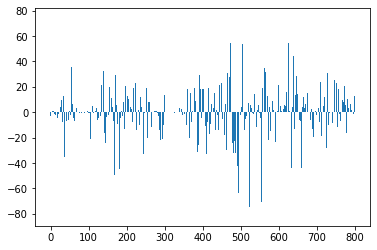

In [ ]:
coefs = reg.coef_
plt.bar([x for x in range(len(coefs))], coefs)
plt.show()

In [ ]:
coef_important = abs(coefs) > np.quantile(abs(coefs), 0.99)
for i in range(len(coef_important)):
  if coef_important[i] == True:
    series_id = features.columns[i]
    print(series_id, fred.get_a_series(series_id)['seriess'][0]['title'], coefs[i])

CES1000000030 Average Weekly Earnings of Production and Nonsupervisory Employees, Mining and Logging 57.29840302747253
CWUR0000SAT1 Consumer Price Index for All Urban Wage Earners and Clerical Workers: Private Transportation in U.S. City Average -74.12245692816455
CPILFENS Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average 73.99633564584973
CWSR0000SACL1E Consumer Price Index for All Urban Wage Earners and Clerical Workers: Commodities Less Food and Energy Commodities in U.S. City Average -63.86866846515025
CWUR0000SA0LE Consumer Price Index for All Urban Wage Earners and Clerical Workers: All Items Less Energy in U.S. City Average -80.09542914153464
WPU067 Producer Price Index by Commodity: Chemicals and Allied Products: Other Chemicals and Allied Products -74.375028318926
WPU01PLUS02 Producer Price Index by Commodity: Farm Products, Processed Foods and Feeds -70.36083316749405
PPIIDC Producer Price Index by Commodity: Industrial Commodit

In [ ]:
y_pred = knn_reg.predict(X_test)
mse(y_test.values, y_pred)

0.034189189189189215

In [ ]:
y_pred = log_reg.predict(X_test_chg)
print(accuracy_score(y_test_chg, y_pred))

0.7972972972972973


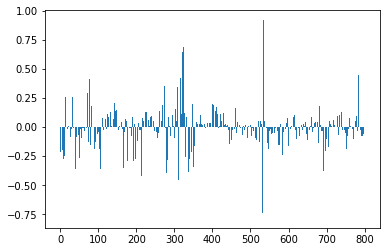

In [ ]:
coefs = log_reg.coef_[0]
plt.bar([x for x in range(len(coefs))], coefs)
plt.show()

In [ ]:
coef_important = abs(coefs) > np.quantile(abs(coefs), 0.99)
for i in range(len(coef_important)):
  if coef_important[i] == True:
    series_id = features.columns[i]
    print(series_id, fred.get_a_series(series_id)['seriess'][0]['title'], coefs[i])

NREVNNFC Nonrevolving Consumer Credit Owned by Nonfinancial Business -0.5287105896862475
DDURRAM1M225NBEA Real Personal Consumption Expenditures: Goods: Durable goods -0.7842737978566734
USREC NBER based Recession Indicators for the United States from the Period following the Peak through the Trough 0.6419307940570844
USRECD NBER based Recession Indicators for the United States from the Period following the Peak through the Trough 0.6419307940570844
USRECM NBER based Recession Indicators for the United States from the Peak through the Trough 0.6854570344674652
WPU0113 Producer Price Index by Commodity: Farm Products: Fresh and Dry Vegetables -0.7423948641622352
WPU01130216 Producer Price Index by Commodity: Farm Products: Dry Onions 0.9163969795544342
WPU0574 Producer Price Index by Commodity: Fuels and Related Products and Power: Residual Fuels (Heavy Fuel Oils, Including #5, #6, and Other Residual Fuels) -0.5110262147184564


In [ ]:
y_pred = knn.predict(X_test_chg)
print(accuracy_score(y_test_chg, y_pred))

0.7162162162162162


C. Write one paragraph to summarize what you have done (including data processing, machine learning model construction) and any concerns that you have observed for the later analysis. 

To process the data, I normalized all of the features.

I then built LinearRegression and KNNRegression machine learning models that attempt to predict the numerical value of unemployment in a given period based on other economic variables from that period.  The KNNRegression model led to a much lower MSE than the LinearRegression model.

I also built LogisticRegression and KNNClassifier machine learning models that attempt to predict whether the unemployment rate is increasing or decreasing in a given period based on other economic variables from that period.  These models led to similar accuracy values (the accuracy for LogisticRegression was higher though).

Before builidng more complex models, I want to further analyze the important features and potentially remove some of the unimportant features.

I also want to explore forecasting unemployment (both its numerical value and whether it is increasing or decreasing) in a given period based on features from previous periods.